In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"
os.chdir("..")
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.completer import complete_by_mean_col, complete_by_mean_col_v2
from utils.completer import complete_by_multi, complete_by_multi_v2
from utils.completer import complete_by_similar_row, complete_by_similar_row_v2
from utils.generator import gen_complete_random
from utils.data import create_adult_dataset

### Reweighing  
[example notebook](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_reweighing_preproc.ipynb)

In [2]:
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

### Try Imputed Data First

In [4]:
data = create_adult_dataset()
data_incomplete = gen_complete_random(data, random_ratio=0.2)
data_complete = complete_by_mean_col(data_incomplete)

gen_complete_random: 58244 NaN values have been inserted


In [5]:
from sklearn.model_selection import train_test_split
tmp_df = pd.concat([data_complete.X, pd.DataFrame(data_complete.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
tmp_df_test, tmp_df_valid = train_test_split(tmp_df_test, test_size=0.5, shuffle=True)
data_imputed_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                     protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                     features_to_keep=data_complete.X.columns.tolist(),
                                     instance_weights_name=None, features_to_drop=[],
                                     custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_imputed_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                    protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                    features_to_keep=data_complete.X.columns.tolist(),
                                    instance_weights_name=None, features_to_drop=[],
                                    custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_imputed_valid = StandardDataset(df=tmp_df_valid, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                     protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                     features_to_keep=data_complete.X.columns.tolist(),
                                     instance_weights_name=None, features_to_drop=[],
                                     custom_preprocessing=None, categorical_features=data_complete.categorical_features)

In [6]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
metric_imputed_train = BinaryLabelDatasetMetric(data_imputed_train, 
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_imputed_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.193524


In [7]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(data_imputed_train)
data_imputed_transf_train = RW.transform(data_imputed_train)

In [8]:
metric_imputed_transf_train = BinaryLabelDatasetMetric(data_imputed_transf_train, 
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_imputed_transf_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [9]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [14]:
def run(train, test, valid):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train.features)
    y_train = train.labels.ravel()
    w_train = train.instance_weights.ravel()

    lmod = LogisticRegression()
    lmod.fit(X_train, y_train, 
            sample_weight=train.instance_weights)
    y_train_pred = lmod.predict(X_train)

    # positive class index
    pos_ind = np.where(lmod.classes_ == train.favorable_label)[0][0]

    dataset_orig_train_pred = train.copy()
    dataset_orig_train_pred.labels = y_train_pred
    
    dataset_orig_valid_pred = valid.copy(deepcopy=True)
    X_valid = scaler.transform(dataset_orig_valid_pred.features)
    y_valid = dataset_orig_valid_pred.labels
    dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

    dataset_orig_test_pred = test.copy(deepcopy=True)
    X_test = scaler.transform(dataset_orig_test_pred.features)
    y_test = dataset_orig_test_pred.labels
    dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

    num_thresh = 100
    ba_arr = np.zeros(num_thresh)
    class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
    for idx, class_thresh in enumerate(class_thresh_arr):
        fav_inds = dataset_orig_valid_pred.scores > class_thresh
        dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
        dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
        classified_metric_orig_valid = ClassificationMetric(valid,
                                                          dataset_orig_valid_pred, 
                                                          unprivileged_groups=unprivileged_groups,
                                                          privileged_groups=privileged_groups)
    
        ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                           +classified_metric_orig_valid.true_negative_rate())

    best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
    best_class_thresh = class_thresh_arr[best_ind]

    print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
    print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)
    
    bal_acc_arr_orig = []
    disp_imp_arr_orig = []
    avg_odds_diff_arr_orig = []

    print("Classification threshold used = %.4f" % best_class_thresh)
    for thresh in tqdm(class_thresh_arr):
    
        if thresh == best_class_thresh:
            disp = True
        else:
            disp = False
    
        fav_inds = dataset_orig_test_pred.scores > thresh
        dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
        dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
        metric_test_bef = compute_metrics(test, dataset_orig_test_pred, 
                                          unprivileged_groups, privileged_groups,
                                          disp = disp)

        bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
        avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
        disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

    %matplotlib inline
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(class_thresh_arr, bal_acc_arr_orig)
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)

    ax2 = ax1.twinx()
    ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
    ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
    ax2.axvline(best_class_thresh, color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()

    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(class_thresh_arr, bal_acc_arr_orig)
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)

    ax2 = ax1.twinx()
    ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
    ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
    ax2.axvline(best_class_thresh, color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()

 45%|████▌     | 45/100 [00:00<00:00, 443.12it/s]

Best balanced accuracy (no reweighing) = 0.7858
Optimal classification threshold (no reweighing) = 0.2278
Classification threshold used = 0.2278
Balanced accuracy = 0.8011
Statistical parity difference = -0.3866
Disparate impact = 0.2653
Average odds difference = -0.2541
Equal opportunity difference = -0.2245
Theil index = 0.0843


100%|██████████| 100/100 [00:00<00:00, 446.27it/s]


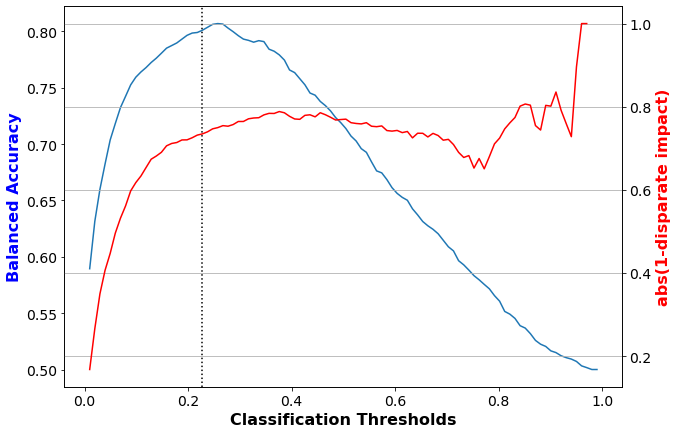

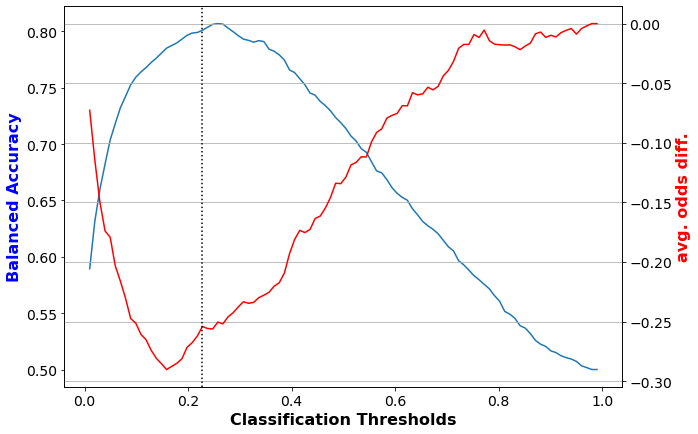

In [15]:
run(data_imputed_train, data_imputed_test, data_imputed_valid)

* abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.  
* average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

 45%|████▌     | 45/100 [00:00<00:00, 444.80it/s]

Best balanced accuracy (no reweighing) = 0.7703
Optimal classification threshold (no reweighing) = 0.2179
Classification threshold used = 0.2179
Balanced accuracy = 0.7915
Statistical parity difference = -0.1913
Disparate impact = 0.5862
Average odds difference = -0.0461
Equal opportunity difference = -0.0079
Theil index = 0.0886


100%|██████████| 100/100 [00:00<00:00, 450.15it/s]


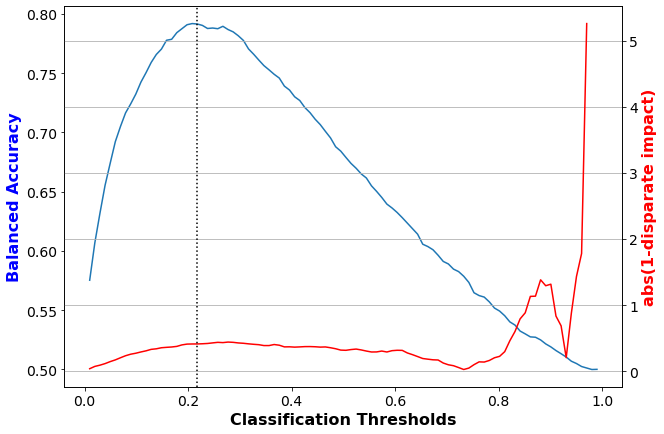

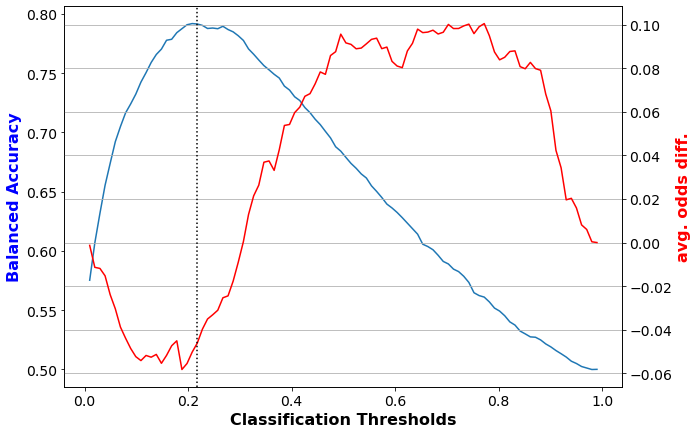

In [16]:
run(data_imputed_transf_train, data_imputed_test, data_imputed_valid)

### Try with Original Dataset

In [32]:
tmp_df = pd.concat([data.X, pd.DataFrame(data.y, columns=["_TARGET_"])], axis=1).copy()
tmp_df['sex'] = tmp_df['sex'].apply(lambda x : 0.0 if x == ' Female' else 1.0) # necessary for aif360 to understand
tmp_df_train, tmp_df_test = train_test_split(tmp_df, test_size=0.3, shuffle=True)
tmp_df_test, tmp_df_valid = train_test_split(tmp_df_test, test_size=0.5, shuffle=True)
data_orig_train = StandardDataset(df=tmp_df_train, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                  protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                  features_to_keep=data_complete.X.columns.tolist(),
                                  instance_weights_name=None, features_to_drop=[],
                                  custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_orig_test = StandardDataset(df=tmp_df_test, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                 protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                 features_to_keep=data_complete.X.columns.tolist(),
                                 instance_weights_name=None, features_to_drop=[],
                                 custom_preprocessing=None, categorical_features=data_complete.categorical_features)
data_orig_valid = StandardDataset(df=tmp_df_valid, label_name="_TARGET_", favorable_classes=lambda x: x > 0,
                                  protected_attribute_names=['sex'], privileged_classes=[[1.0]],
                                  features_to_keep=data_complete.X.columns.tolist(),
                                  instance_weights_name=None, features_to_drop=[],
                                  custom_preprocessing=None, categorical_features=data_complete.categorical_features)
metric_orig_train = BinaryLabelDatasetMetric(data_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.195852


In [33]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(data_orig_train)
data_orig_transf_train = RW.transform(data_orig_train)
metric_orig_transf_train = BinaryLabelDatasetMetric(data_orig_transf_train, 
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_transf_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


 43%|████▎     | 43/100 [00:00<00:00, 421.13it/s]

Best balanced accuracy (no reweighing) = 0.8140
Optimal classification threshold (no reweighing) = 0.2377
Classification threshold used = 0.2377
Balanced accuracy = 0.8101
Statistical parity difference = -0.3597
Disparate impact = 0.2798
Average odds difference = -0.2068
Equal opportunity difference = -0.1569
Theil index = 0.0841


100%|██████████| 100/100 [00:00<00:00, 436.36it/s]


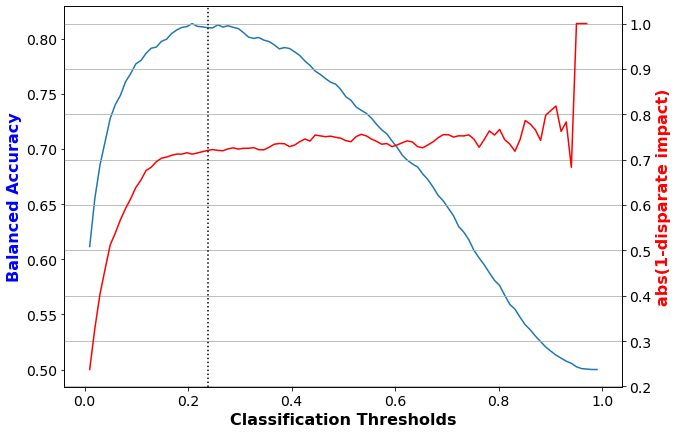

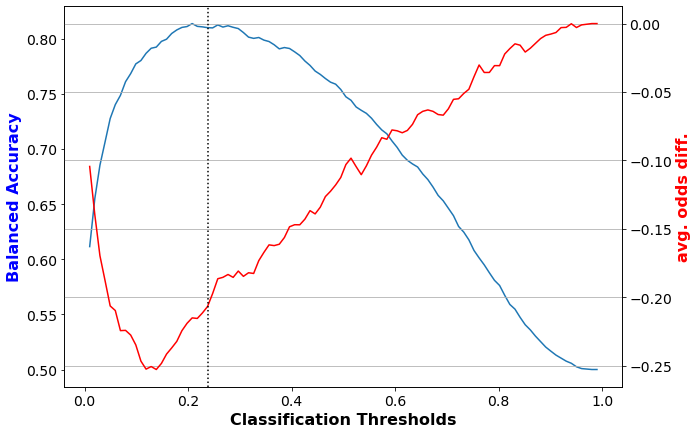

In [34]:
run(data_orig_train, data_orig_test, data_orig_valid)

 45%|████▌     | 45/100 [00:00<00:00, 441.68it/s]

Best balanced accuracy (no reweighing) = 0.8028
Optimal classification threshold (no reweighing) = 0.2377
Classification threshold used = 0.2377
Balanced accuracy = 0.8051
Statistical parity difference = -0.1968
Disparate impact = 0.5368
Average odds difference = -0.0315
Equal opportunity difference = 0.0265
Theil index = 0.0894


100%|██████████| 100/100 [00:00<00:00, 446.80it/s]


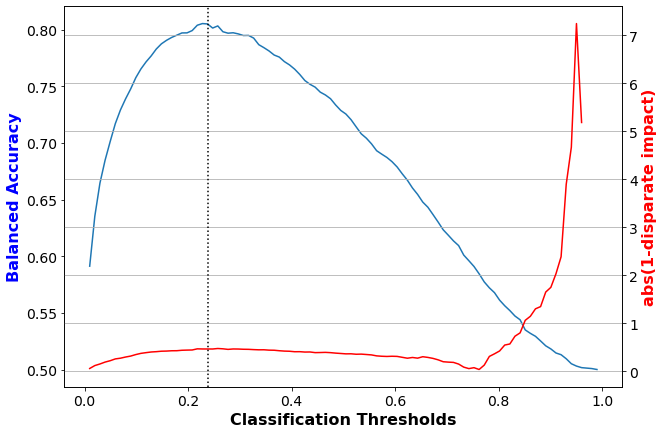

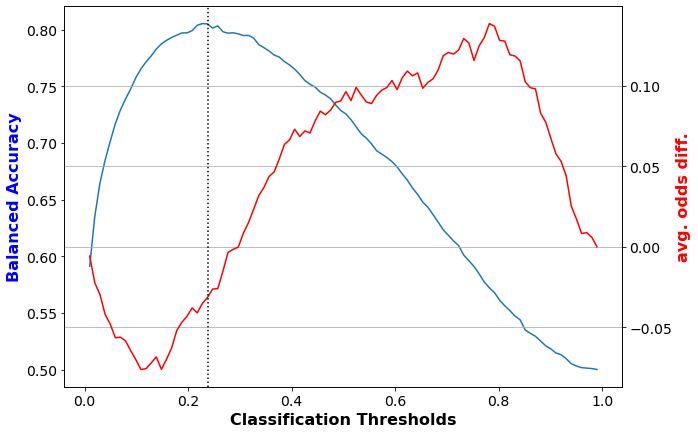

In [35]:
run(data_orig_transf_train, data_orig_test, data_orig_valid)